In [8]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pplt
import seaborn as sns

plt.style.use('ggplot')
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk

In [2]:
df = pd.read_csv("D:/Work/Sentiment Analysis/Datasets/Reviews.csv")
df = df.head(500)
print(df.shape)

(500, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 0, 'Review Stars')

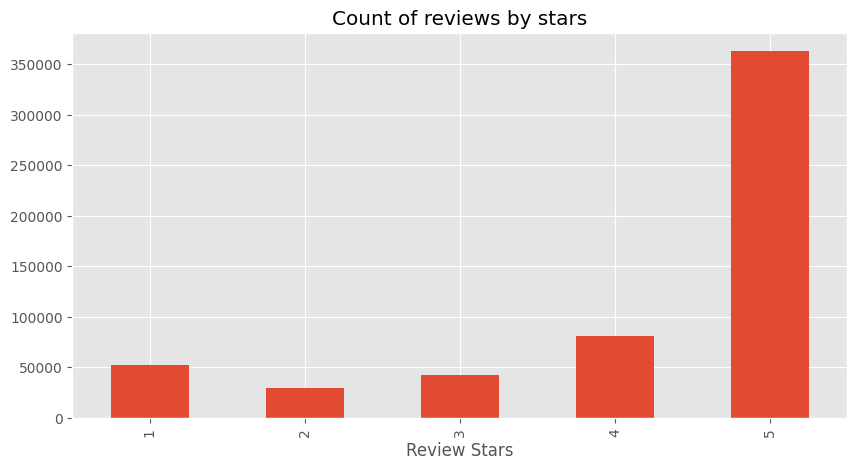

In [4]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of reviews by stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')


In [3]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


## roBERTa model

In [4]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [6]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='tf')

    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict


In [9]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):

    text = row['Text']
    myid = row['Id']
    roberta_result = polarity_scores_roberta(text)
    res[myid] = roberta_result
    


  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
res[myid]

{'roberta_neg': 0.0024394493,
 'roberta_neu': 0.011326441,
 'roberta_pos': 0.9862342}

In [11]:
polarity_scores_roberta(example)

{'roberta_neg': 0.976363,
 'roberta_neu': 0.020680457,
 'roberta_pos': 0.0029566232}

In [12]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [13]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009622,0.049968,0.940410,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.509003,0.452390,0.038607,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003234,0.098143,0.898624,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002297,0.090337,0.907366,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001634,0.010301,0.988065,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Text(0.5, 1.0, 'negative')

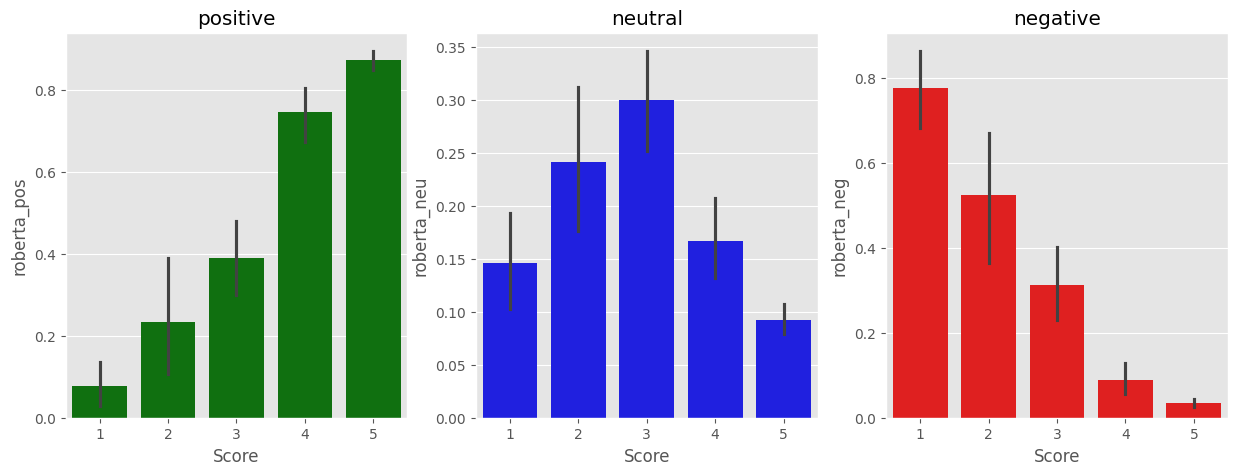

In [14]:
fig, axs = pplt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0], color='green')
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1], color='blue')
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2], color='red')
axs[0].set_title('positive')
axs[1].set_title('neutral')
axs[2].set_title('negative')